# BGC-Argo Workflow 

Here Argo are listed within the region seperated and joined for joint analysis, Argo were selected for having CHLa


In [22]:
# Immporting Labriaries
# IF not available, install using pip install <package-name>

# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import cmocean


In [23]:
# Base filepath
root = '../data/GO-BGC Workshop/'
profile_dir = root + 'Profiles/'
natl_dir = profile_dir + 'North_Atlantic/'

# Create GO-BGC folders if they do not exist yet
if 'GO-BGC Workshop' not in os.listdir('../data/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)
if 'North_Atlantic' not in os.listdir(profile_dir):
  os.mkdir(natl_dir)

## 2. Functions to download float dara

Below are two functions that we created:

1. The function `download_file()` downloads a single file from a specified URL.

2. The function `argo_gdac()` downloads the index file that describes all synthetic float profiles (Sprof files), subsets it using space, time, sensor, and float criteria, then downloads the relevant float data files from the [US-GODAE Global Data Assembly Center (GDAC)](https://www.usgodae.org/ftp/outgoing/argo/). The function can also subset the index file without downloading new float data.

Run the two cells to save the functions into Python's namespace. For information about their arguments, see the documentation text inside each function.

In [24]:
# Function to download a single file
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [25]:
# Function to download and parse GDAC synthetic profile index file
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (<list of WMOIDs>, <DataFrame of index file subset>,
                                                            <list of downloaded filenames [if applicable]>)
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

# 3. Download data from a single float

We'll use the function `argo_gdac()` to download a single float's data (note that the argument `floats` is specified).

Here I am downloading float 4903659, a float deployed in the icelandic shelf in the mid 2010's where it spent two years before drifting across into the Isminder sea

In [26]:
wmoids, gdac_index, downloaded_filenames \
                   = argo_gdac(lat_range=None,lon_range=None,
                               start_date=None,end_date=None,
                               sensors=None,floats=4903659,
                               overwrite_index=False,overwrite_profiles=False,
                               skip_download=False,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

>>> File argo_synthetic-profile_index.txt already exists. Leaving current version.


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_11576/3441803214.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


>>> File 4903659_Sprof.nc already exists. Leaving current version.


After downloading the data, the function returns three variables, which we named `wmoids`, `gdac_index`, and `downloaded_filenames`.

The variable `wmoids` is a list of the WMOID numbers of floats that were downloaded. In this example, only one float is included:

In [27]:
wmoids

array([4903659])

The variable `downloaded_filenames` is a list of the actual files that were downloaded:

In [28]:
downloaded_filenames

['4903659_Sprof.nc']

In [29]:
gdac_index.head(5)

,file,date,latitude,longitude,ocean,profiler_type,institution,parameters,parameter_data_mode,date_update,wmoid,filepath_main,filepath,filename
167846,coriolis/4903659/profiles/SR4903659_001.nc,2024-05-29 12:51:22,60.012,-23.861,A,834,IF,PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...,RRRARRRRAAARR,2025-06-10 16:14:23,4903659,coriolis/4903659/,coriolis/4903659/profiles/,SR4903659_001.nc
167847,coriolis/4903659/profiles/SR4903659_001D.nc,2024-05-28 10:01:58,59.998,-23.997,A,834,IF,PRES TEMP PSAL CHLA CHLA_FLUORESCENCE BBP700 C...,RRRAAAR,2025-06-10 16:14:13,4903659,coriolis/4903659/,coriolis/4903659/profiles/,SR4903659_001D.nc
167848,coriolis/4903659/profiles/SR4903659_002.nc,2024-05-31 12:20:27,60.017,-23.783,A,834,IF,PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...,RRRARRRRAAARR,2025-06-10 16:14:43,4903659,coriolis/4903659/,coriolis/4903659/profiles/,SR4903659_002.nc
167849,coriolis/4903659/profiles/SR4903659_002D.nc,2024-05-29 13:32:10,60.012,-23.861,A,834,IF,PRES TEMP PSAL CHLA CHLA_FLUORESCENCE BBP700 C...,RRRAAAR,2025-06-10 16:14:33,4903659,coriolis/4903659/,coriolis/4903659/profiles/,SR4903659_002D.nc
167850,coriolis/4903659/profiles/SR4903659_003.nc,2024-06-02 23:48:06,59.924,-23.522,A,834,IF,PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...,RRRARRRRAAARR,2025-06-10 16:15:02,4903659,coriolis/4903659/,coriolis/4903659/profiles/,SR4903659_003.nc


# 4. Load netCDF file, examine data structure, and plot float trajectory

Looking at the tutorial provided in by Flavien Petit

In [32]:
data = xr.open_dataset(profile_dir + downloaded_filenames[0])
data = data.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
display(data)

<xarray.Dataset> Size: 48MB
Dimensions:                            (PROF_NUM: 68, N_PARAM: 15, N_CALIB: 1,
                                        N_LEVELS: 1486)
Coordinates:
  * PROF_NUM                           (PROF_NUM) float64 544B 1.0 1.0 ... 44.0
Dimensions without coordinates: N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/134)
    DATA_TYPE                          object 8B ...
    FORMAT_VERSION                     object 8B ...
    HANDBOOK_VERSION                   object 8B ...
    REFERENCE_DATE_TIME                object 8B ...
    DATE_CREATION                      object 8B ...
    DATE_UPDATE                        object 8B ...
    ...                                 ...
    BISULFIDE                          (PROF_NUM, N_LEVELS) float32 404kB ...
    BISULFIDE_QC                       (PROF_NUM, N_LEVELS) object 808kB ...
    BISULFIDE_dPRES                    (PROF_NUM, N_LEVELS) float32 404kB ...
    BISULFIDE_ADJUSTED                 (PROF_NUM, N_LEVELS) float32 404kB ...
    BISULFIDE_ADJUSTED_QC              (PROF_NUM, N_LEVELS) object 808kB ...
    BISULFIDE_ADJUSTED_ERROR           (PROF_NUM, N_LEVELS) float32 404kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2025-06-10T16:25:53Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.19 (version 12.05.2025 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

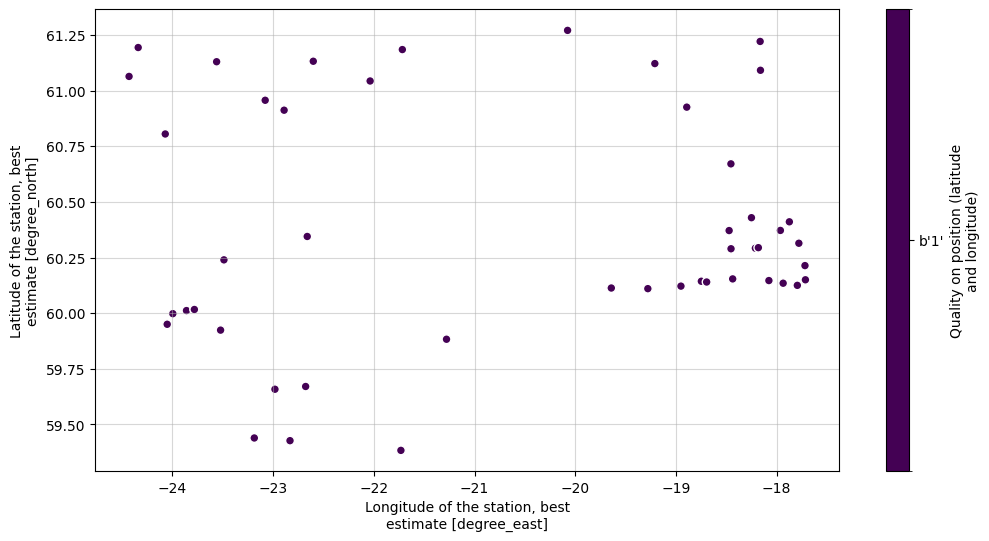

In [ ]:
# Here, we use `xarray`'s built-in plotting library to create a quick longitude vs. latitude scatter plot of the float's trajectory. We color the points by the `POSITION_QC` flag.

#The positions flagged as '8' are straight lines because they are linearly interpolated while the float disappears under sea ice every winter.

plt.figure(figsize=(12,6))
data.plot.scatter(x = 'LONGITUDE', y = 'LATITUDE', hue='POSITION_QC',s=40)
plt.grid(alpha=0.5)

# 5. Profile timestaps and Cycle numbers

Thanks to `xarray`'s datetime integration, the timestamps (`JULD`) are recognized in the correct format:

In [41]:
data['JULD']

<xarray.DataArray 'JULD' (PROF_NUM: 68)> Size: 544B
[68 values with dtype=datetime64[ns]]
Coordinates:
  * PROF_NUM  (PROF_NUM) float64 544B 1.0 1.0 2.0 2.0 ... 41.0 42.0 43.0 44.0
Attributes:
    long_name:      Julian day (UTC) of the station relative to REFERENCE_DAT...
    standard_name:  time
    conventions:    Relative julian days with decimal part (as parts of day)
    axis:           T
    resolution:     0.0006944444444444445

In [42]:
timestamps = data['JULD'].values

print(timestamps)

['2024-05-28T10:01:58.000000512' '2024-05-29T12:51:21.999994880'
 '2024-05-29T13:32:10.003441152' '2024-05-31T12:20:26.988268544'
 '2024-05-31T13:04:32.000000000' '2024-06-02T23:48:05.999998976'
 '2024-06-03T00:35:36.999995904' '2024-06-06T11:48:06.000002048'
 '2024-06-06T12:32:23.999996928' '2024-06-08T23:46:06.999997440'
 '2024-06-09T00:32:43.000004608' '2024-06-12T11:46:06.999999488'
 '2024-06-12T12:36:57.000004608' '2024-06-14T23:46:07.000001024'
 '2024-06-15T00:36:05.000005120' '2024-06-18T11:54:03.999997440'
 '2024-06-18T12:39:39.000001024' '2024-06-19T12:51:22.000003072'
 '2024-06-19T13:33:48.000000512' '2024-06-20T12:53:24.000004096'
 '2024-06-20T13:35:54.000001024' '2024-06-21T05:17:22.000002560'
 '2024-06-21T08:37:32.003215872' '2024-06-22T12:51:22.981970944'
 '2024-06-22T13:36:16.000002560' '2024-06-23T13:32:52.000001024'
 '2024-06-23T14:05:07.994549760' '2024-06-24T12:55:21.022133760'
 '2024-06-24T13:40:45.000001536' '2024-06-25T12:53:22.000006144'
 '2024-06-25T13:35:46.999

In [43]:
print(type(timestamps[0]))

<class 'numpy.datetime64'>


Number of profiles this Argo has

In [44]:
prof_nums = data['PROF_NUM'].values

display(prof_nums)

array([ 1.,  1.,  2.,  2.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,  6.,  7.,
        7.,  8.,  8.,  9.,  9., 10., 10., 11., 11., 12., 12., 13., 13.,
       14., 14., 15., 15., 16., 16., 17., 17., 18., 18., 19., 19., 20.,
       20., 21., 21., 22., 22., 23., 23., 24., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44.])

In [45]:
len(prof_nums)

68

In [46]:
prof_nums[-1]

np.float64(44.0)

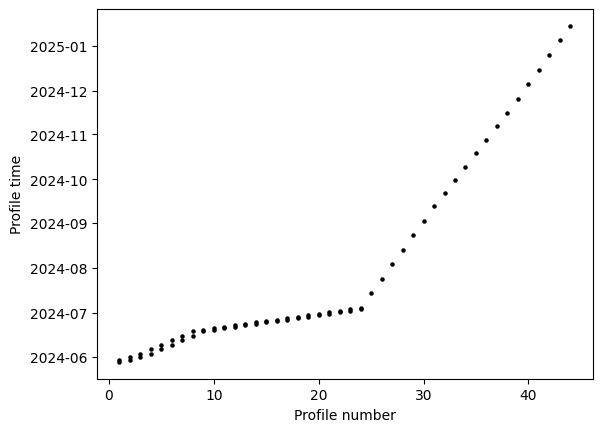

In [49]:
plt.scatter(prof_nums,timestamps,c='k',s=5)
plt.xlabel('Profile number')
plt.ylabel('Profile time');

# Check Pressure Coordinate
Displaying the quality-controlled pressure variable (`PRES_ADJUSTED`), we see that there seem to be 557 depth levels (`N_LEVELS`). However, this is just the maximum number of synthetic levels across all of the profiles. Not all profiles will necessarily have measurements at all 557 depth levels.

The attributes panel shows us that the units are decibars (dbar).


In [50]:
data['PRES_ADJUSTED']

<xarray.DataArray 'PRES_ADJUSTED' (PROF_NUM: 68, N_LEVELS: 1486)> Size: 404kB
[101048 values with dtype=float32]
Coordinates:
  * PROF_NUM  (PROF_NUM) float64 544B 1.0 1.0 2.0 2.0 ... 41.0 42.0 43.0 44.0
Dimensions without coordinates: N_LEVELS
Attributes:
    long_name:       Sea water pressure, equals 0 at sea-level
    standard_name:   sea_water_pressure
    units:           decibar
    valid_min:       0.0
    valid_max:       12000.0
    C_format:        %.3f
    FORTRAN_format:  F.3
    resolution:      0.001
    axis:            Z

In [51]:
data['PRES_ADJUSTED'].attrs['units']

'decibar'

In [52]:
data['PRES_ADJUSTED'].values

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [ 0.62,  0.62,  0.62, ...,   nan,   nan,   nan],
       [ 0.56,  0.56,  0.56, ...,   nan,   nan,   nan],
       [-8.38, -7.38, -5.48, ...,   nan,   nan,   nan]],
      shape=(68, 1486), dtype=float32)

In [53]:
first_profile_pressure = data['PRES_ADJUSTED'].isel(PROF_NUM=0).values

In [54]:
display(first_profile_pressure[:10])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [55]:
display(first_profile_pressure[-10:])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

# 7. Difference in sampling beween physical and chemical/biological sensors
Checking for the first 50 vertical levels of the first salinity profile, measuerments are provided at each level

In [59]:
first_profile_salinity = data['PSAL_ADJUSTED'].values[3]

display(first_profile_salinity[:50])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)